## k Nearest Neighbors

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import scipy
from matplotlib.colors import ListedColormap
from functools import partial

### Load the modified Iris dataset

In [2]:
# Iris dataset.
iris = datasets.load_iris()     # Load Iris dataset.

X = iris.data                   # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.

Y = (iris.target > 1.5).reshape(-1,1).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
Y[Y==0] = -1                    # Convert labels from {0, 1} to {-1, 1}

X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
np.random.seed(1)               # Set the random seed.
np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

print(X.shape)
print(Y.shape)
print(X_and_Y[0])               # Should be: [5.8 4.  1.2 0.2 -1. ].

(150, 4)
(150, 1)
[ 5.8  4.   1.2  0.2 -1. ]


In [3]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:4]
Y_shuffled = X_and_Y[:,4]

X_train = X_shuffled[:50][:, [3,1]]     # Shape: (50,2)
Y_train = Y_shuffled[:50]               # Shape: (50,)
X_val   = X_shuffled[50:100][:, [3,1]]  # Shape: (50,2)
Y_val   = Y_shuffled[50:100]            # Shape: (50,)
X_test  = X_shuffled[100:][:, [3,1]]    # Shape: (50,2)
Y_test  = Y_shuffled[100:]              # Shape: (50,)
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(50, 2)
(50,)
(50, 2)
(50,)
(50, 2)
(50,)


### Visualization

In [4]:
def vis(X, Y, knn_classifier=None):
    # Visualize k-NN.
    if knn_classifier is not None:
        # Calculate min, max and create grids.
        h = .02
        x0_min, x0_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
        x1_min, x1_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
        x0s, x1s = np.meshgrid(np.arange(x0_min, x0_max, h),
                               np.arange(x1_min, x1_max, h))
        xs = np.stack([x0s, x1s], axis=-1).reshape(-1, 2)

        # Predict class using kNN classifier and data.
        ys_pred = np.array([knn_classifier(x) for x in xs])
        ys_pred = ys_pred.reshape(x0s.shape)

        # Put the result into a color plot.
        # Color map: #00AAFF - blue, #FFAAAA - red, #AAFFAA - green
        
        cmap_light = ListedColormap(['#00AAFF', '#FFAAAA'])
        plt.pcolormesh(x0s, x1s, ys_pred, cmap=cmap_light, alpha=0.3)
    
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1], 
                c='blue', label='class -1', alpha=0.3)
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1], 
                c='red', label='class +1', alpha=0.3)
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    plt.show()

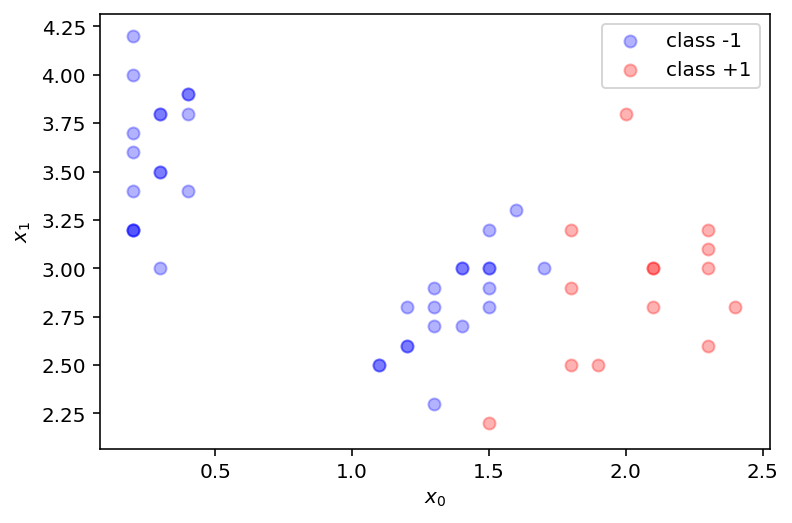

In [5]:
# Visualize training set.
vis(X_train, Y_train)
# Note that some points have darker color since there can be 
# multiple points at the same location.

### k Nearest Neighbors

In [43]:
# Euclidean distance.
from scipy.spatial import distance
def calc_distance(x1, x2):
    # x1, x2 are two NumPy vectors
    # Return the Euclidean distance between x1 and x2. It should be a scalar. 
    dist = distance.euclidean(x1,x2)
    return dist
    
# k nearest neighbor predictor.
def f_knn(x, X_train, Y_train, k):
    # Create the list of (distance, label) pairs.
    dist_label_pairs = []
    for xi, yi in zip(X_train, Y_train):
        # Calculate the distance.
        dist = calc_distance(xi, x)
        # Add a (distance, label) pair to the list.
        dist_label_pairs.append((dist, yi))
    # Sort the pairs by distance (ascending).
    sorted_dist_label_pairs = sorted(dist_label_pairs, key=lambda x:x[0])
    # Obtain the first k pairs (corresponding to k smallest distances).
    k_dist_label_pairs = sorted_dist_label_pairs[:k]
    # Extract the labels of the k pairs.
    k_labels=[]
    for label_pair in k_dist_label_pairs:
        k_label=label_pair[1]
        k_labels.append(k_label)   
    # Count the number of +1 predictions and -1 predictions.
    pos1_in_k_labels = 0 
    neg1_in_k_labels = 0
    for label in k_labels:
        if label == +1:
            pos1_in_k_labels += 1
        elif label == -1:
            neg1_in_k_labels += 1
    # Make the prediction based on counts.
    if pos1_in_k_labels > neg1_in_k_labels:
        y_pred = +1
    else:
        y_pred = -1

    return y_pred
    
# Judge function: 1(a != b). It supports scalar, vector and matrix.
def judge(a, b):
    return np.array(a != b).astype(np.float32)

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, knn_classifier):
    e = 0
    n = len(X)
    for (xi, yi) in zip(X, Y):
        e += judge(yi, knn_classifier(xi))
    e = 1.0 * e / n
    return e

### Visualize the results

k=1


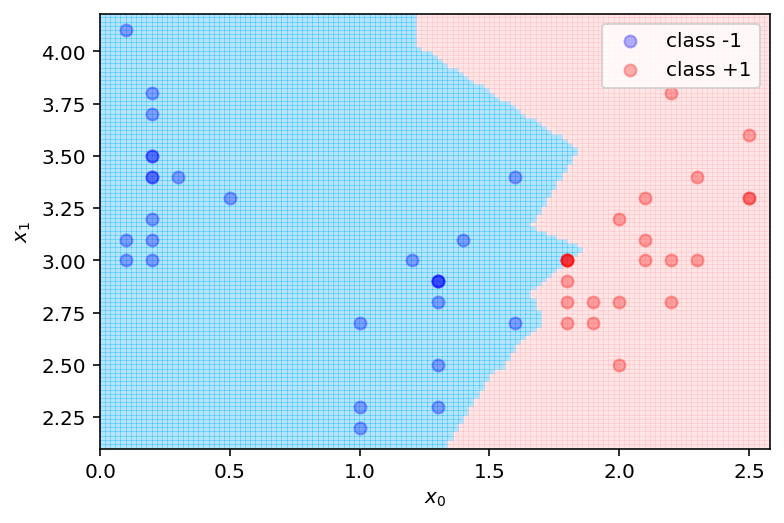

Validation error: 0.08

k=2


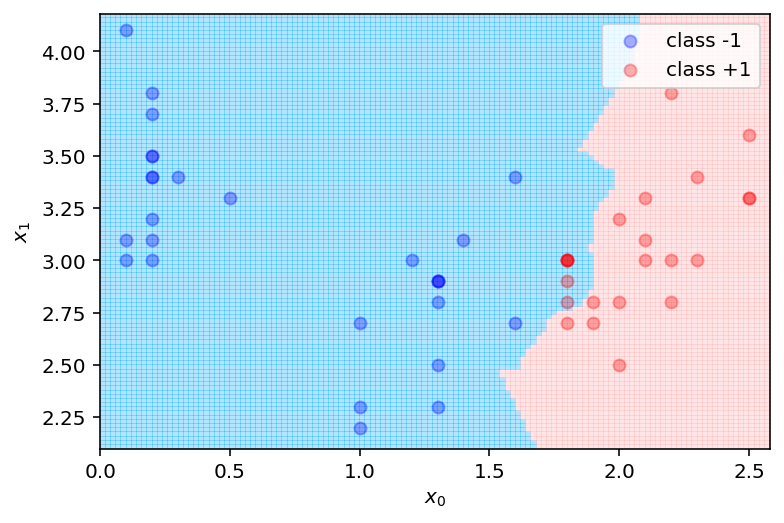

Validation error: 0.12

k=3


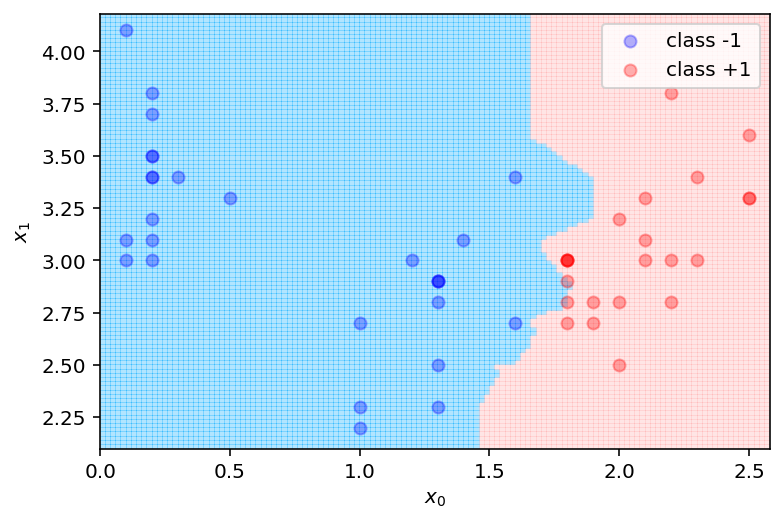

Validation error: 0.02



In [44]:
opt_val_error = 1.0
opt_k = None

# Try different k(s).
for k in [1,2,3]:
    # Visualize 
    #   1. Validation set (as points).
    #   2. Decision boundary from training set (as background).
    print("k={}".format(k))
    # Create a k-NN classifier with training set.
    knn_classifier = partial(f_knn, X_train=X_train, Y_train=Y_train, k=k)
    # Visualization.
    vis(X_val, Y_val, knn_classifier)
    # Calculate validation error.
    val_error = calc_error(X_val, Y_val, knn_classifier)
    print("Validation error: {}\n".format(val_error))
    if val_error < opt_val_error:
        opt_val_error = val_error
        opt_k = k
        opt_knn_classifier = knn_classifier

Best k=3


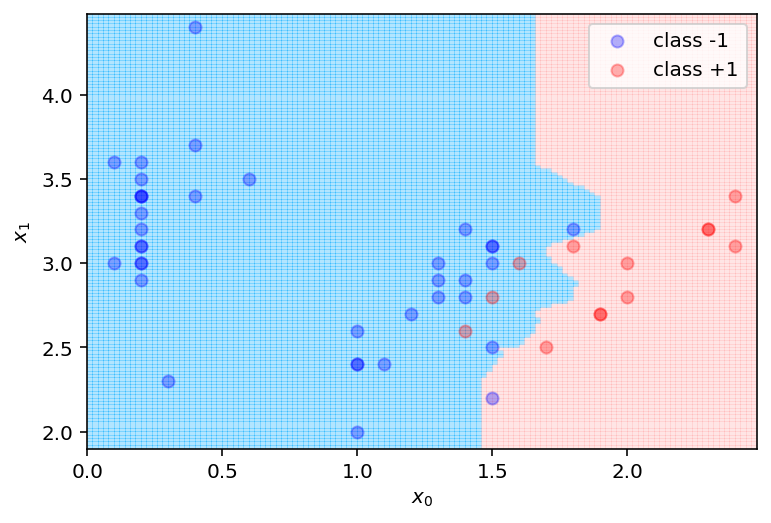

Test error: 0.08


In [45]:
print("Best k={}".format(opt_k))
test_error = calc_error(X_test, Y_test, opt_knn_classifier)
vis(X_test, Y_test, opt_knn_classifier)
print("Test error: {}".format(test_error))